In [245]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

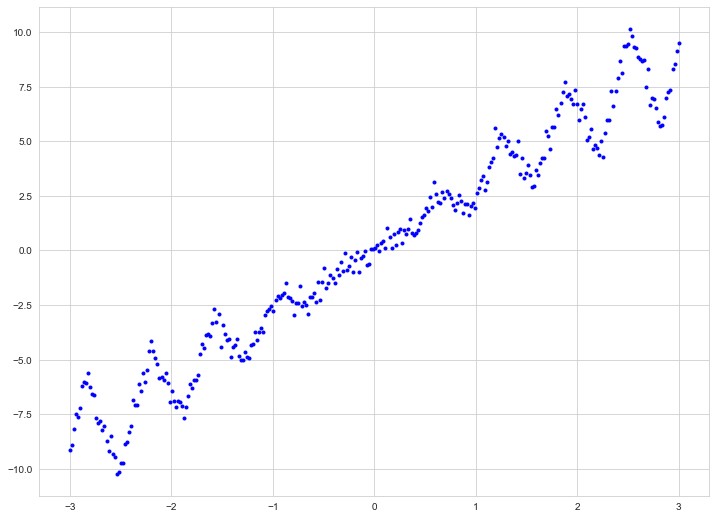

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [13]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")
    plt.plot(X.reshape(-1), y.reshape(-1), "b.")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

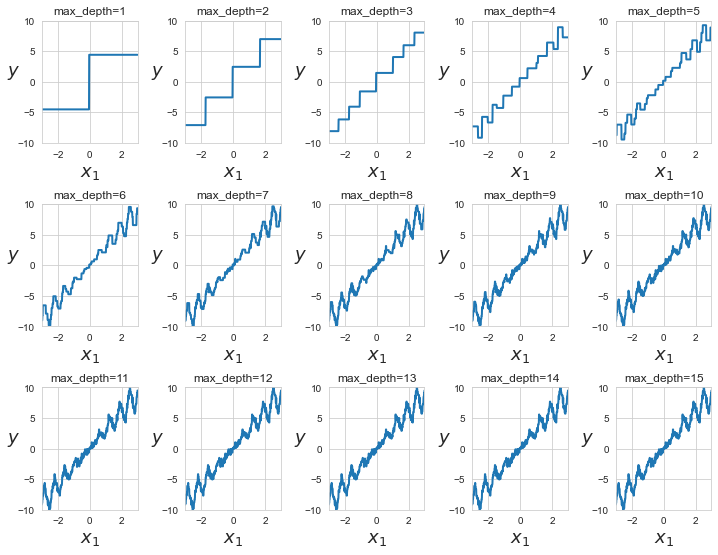

In [25]:
for i in range(1, 16):
    reg = DecisionTreeRegressor(max_depth=i).fit(X, y)
    plt.subplot(3, 5, i)
    plot_regression_predictions(reg, X=X, y=y)
    plt.title(f'max_depth={i}')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

Оптимальной выглядит модель с глубиной 7. У моделей с меньшей глубиной - высокий bias, у моделей с глубиной больше 7 - высокий variance

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

Text(0, 0.5, 'вероятность классифицировать правильно')

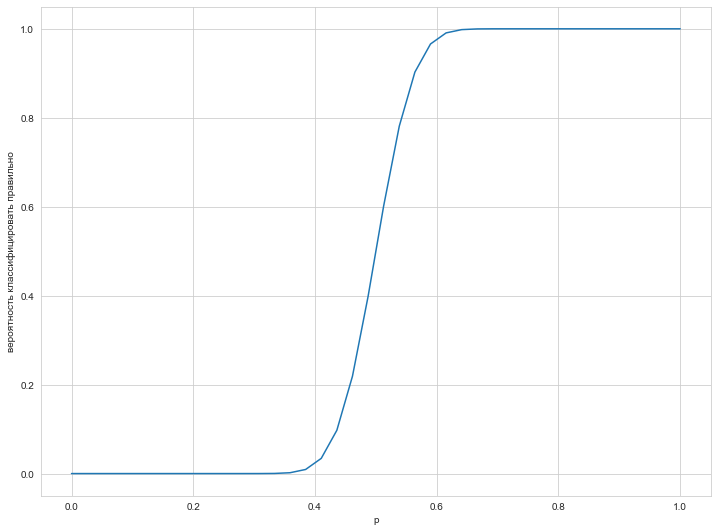

In [46]:
prob = []
step = np.linspace(0,1,40)
for p in step:
    sum_p = 0
    for i in range(51, 102):
        sum_p += math.comb(101,i)*(p**i)*((1-p)**(101-i))
    prob.append(sum_p)
plt.plot(step,prob)
plt.xlabel('p')
plt.ylabel('вероятность классифицировать правильно')

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

Text(0, 0.5, 'вероятность классифицировать правильно')

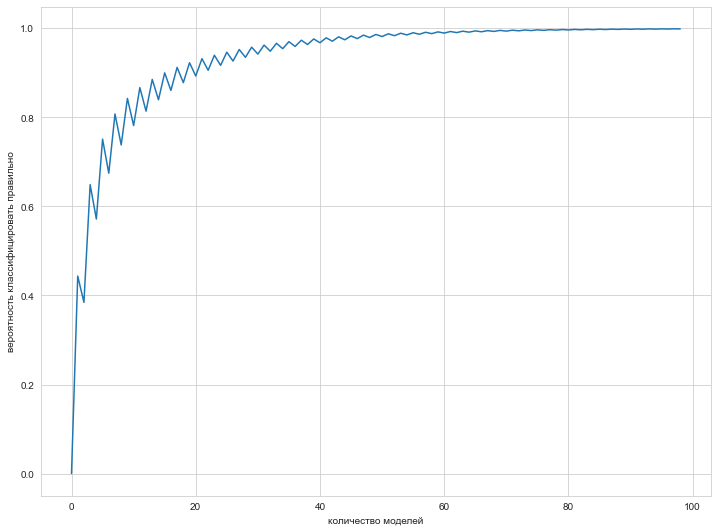

In [328]:
prob = []
p = 0.65
for i in range(2,101):
    n = i//2+1
    sum = 0
    for j in range(n, i):
        res = math.comb(i,j)*(p**j)*((1-p)**(i-j))
        sum += res
    prob.append(sum)
plt.plot(prob)
plt.xlabel('количество моделей')
plt.ylabel('вероятность классифицировать правильно')

Опишите ваши наблюдения:

* с вероятностью p=0.6 для каждого отдельного классификатора результирующая вероятность правильности предсказания почти равна 1
* При увеличении количества моделей точность предсказаний сначала сильно возрастает, а затем в районе 40 выходит на плато

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [162]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for i in range(1, self.n_estimators+1):
            np.random.seed(self.random_state + i)
            ids_by_tree = np.random.choice(range(X.shape[1]), size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(ids_by_tree)
            poses = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            x_boot = X[poses][:,ids_by_tree]
            y_boot = y[poses]
            classifier = DecisionTreeClassifier(max_depth=self.max_depth,
                                                max_features = self.max_features,
                                                random_state=self.random_state + i)
            fitted_clf = classifier.fit(x_boot, y_boot)
            self.trees.append(fitted_clf)
        return self

    def predict_proba(self, X):
        proba_mean = np.zeros((X.shape[0], len(self.classes_)))
        probas = []
        for i in range(len(self.trees)):
            tree = self.trees[i]
            idxs = self.feat_ids_by_tree[i]
            X_idx = X[:,idxs]
            tree_probas = tree.predict_proba(X_idx)
            probas.append(tree_probas)
        probas = np.array(probas)
        for i in range(proba_mean.shape[0]):
            for j in range(proba_mean.shape[1]):
                proba_mean[i][j]=np.mean(probas[:,i,j])
        return proba_mean

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [51]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

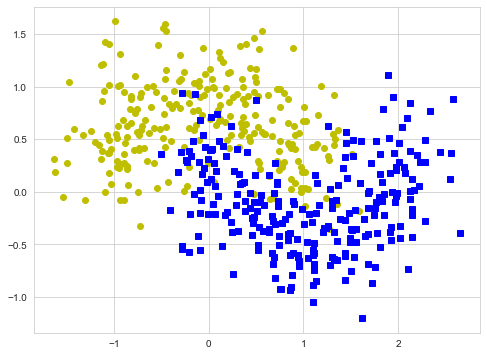

In [48]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [87]:
X_train.shape

(400, 2)

In [163]:
rf_clf = RandomForestClassifierCustom(max_features=2)
rf_clf.fit(X_train, y_train)
rf_clf.predict_proba(X_test)

array([[1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0.9, 0.1],
       [0. , 1. ],
       [0. , 1. ],
       [0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0.6, 0.4],
       [0.4, 0.6],
       [1. , 0. ],
       [0. , 1. ],
       [0.3, 0.7],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.9, 0.1],
       [0. , 1. ],
       [0.6, 0.4],
       [0.9, 0.1],
       [0.1, 0.9],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0.7, 0.3],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.2, 0.8],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.8, 0.2],
       [0.9, 0.1],
       [1. , 0. ],
       [0.3,

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

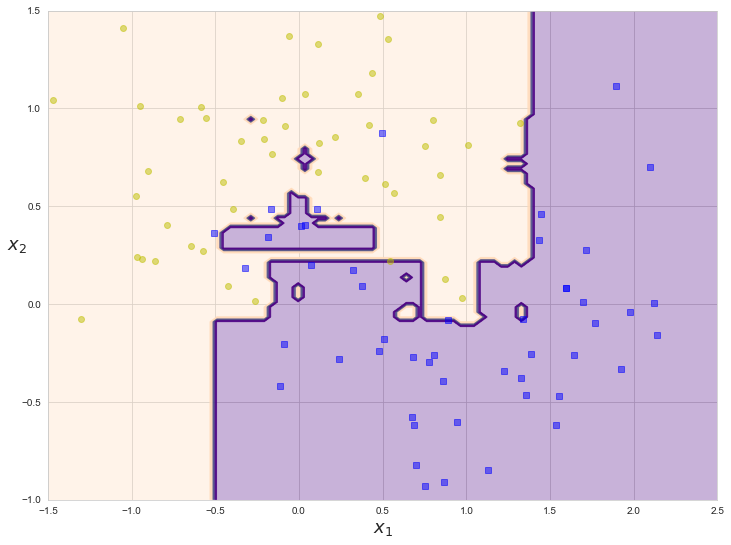

In [164]:
plot_decision_boundary(rf_clf, X_test, y_test)

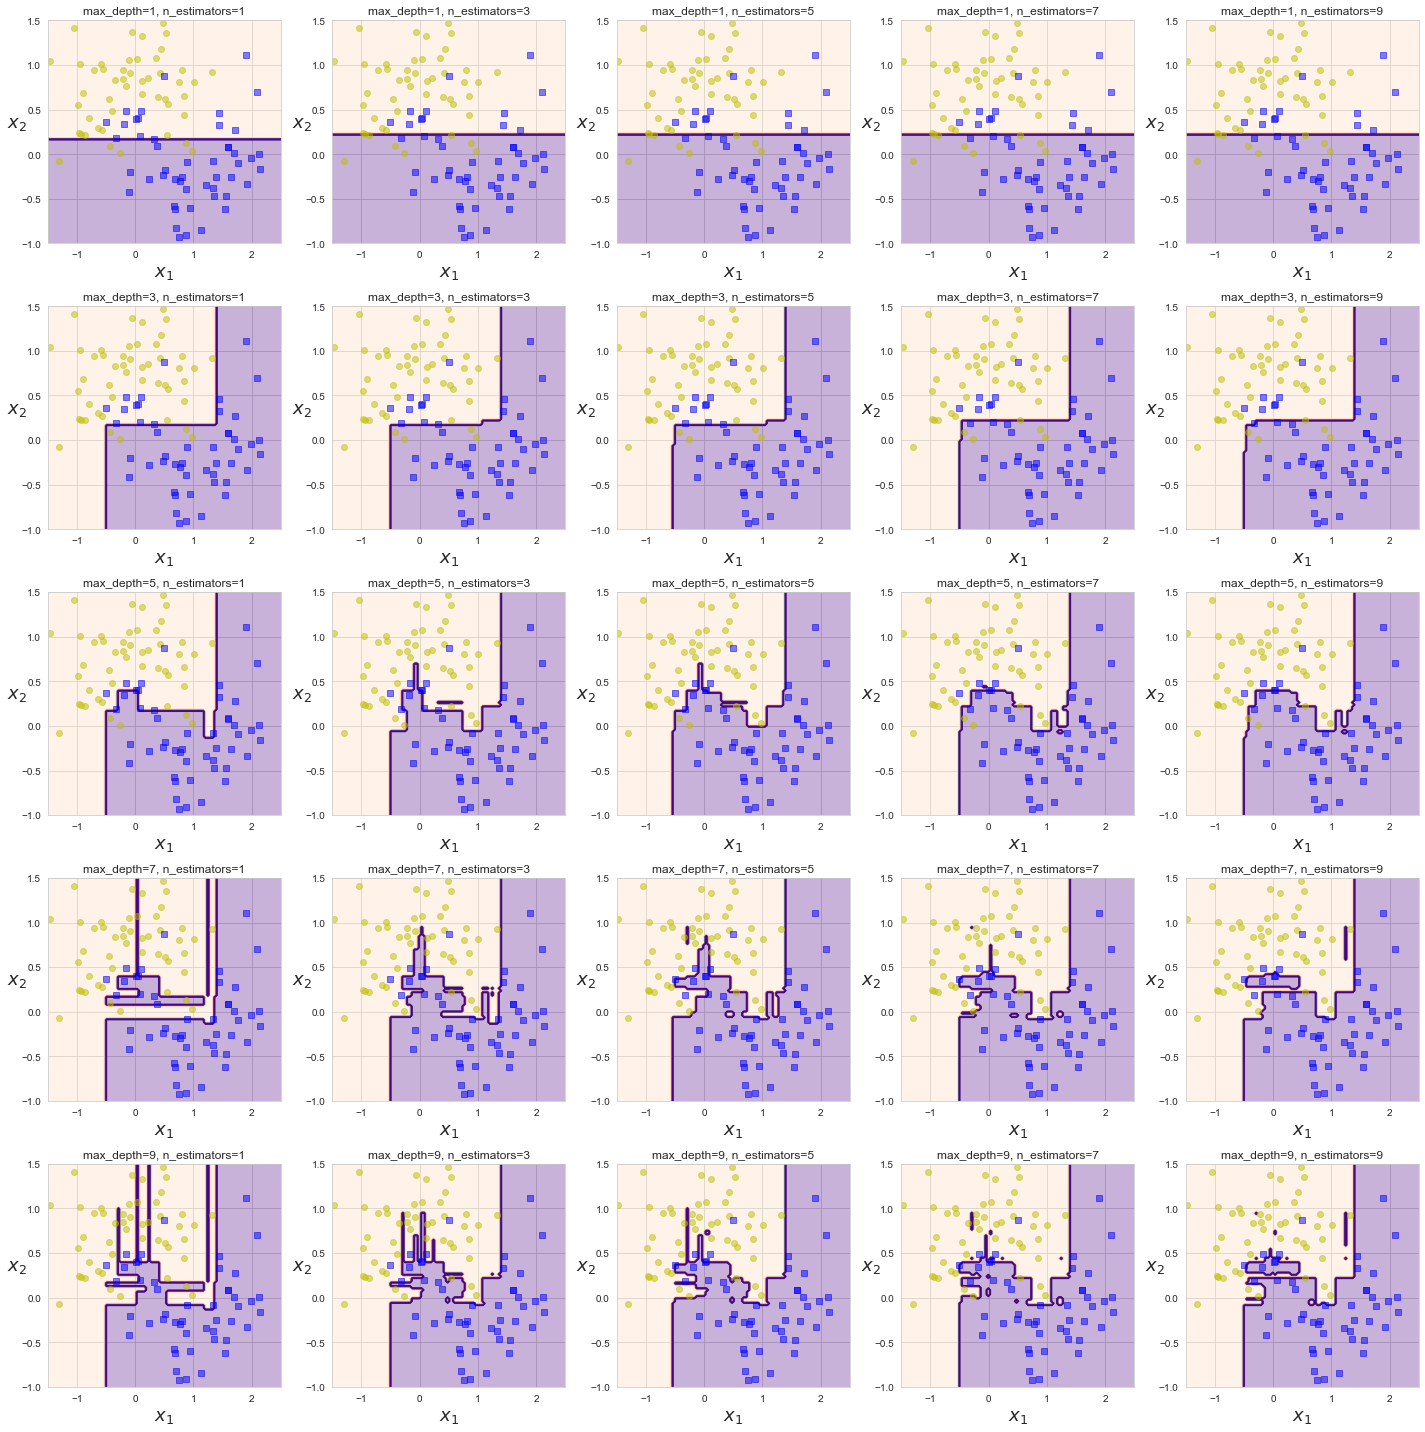

<Figure size 720x720 with 0 Axes>

In [180]:
plot_place=1
plt.figure(figsize=(20, 20))
for depth in range(1,10,2):
    for estim in range(1,10,2):
        clasif = RandomForestClassifierCustom(max_depth=depth, max_features=2, n_estimators=estim)
        clasif.fit(X_train,y_train)
        plt.subplot(5,5,plot_place)
        plt.tight_layout()
        plot_decision_boundary(clasif, X_test, y_test)
        plt.title(f'max_depth={depth}, n_estimators={estim}')
        plot_place += 1
plt.figure(figsize=(10,10))
plt.show()

На мой взгляд, лучше всего брать параметры `max_depth=5` и `n_estimators=9`

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [183]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [184]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [187]:
X

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

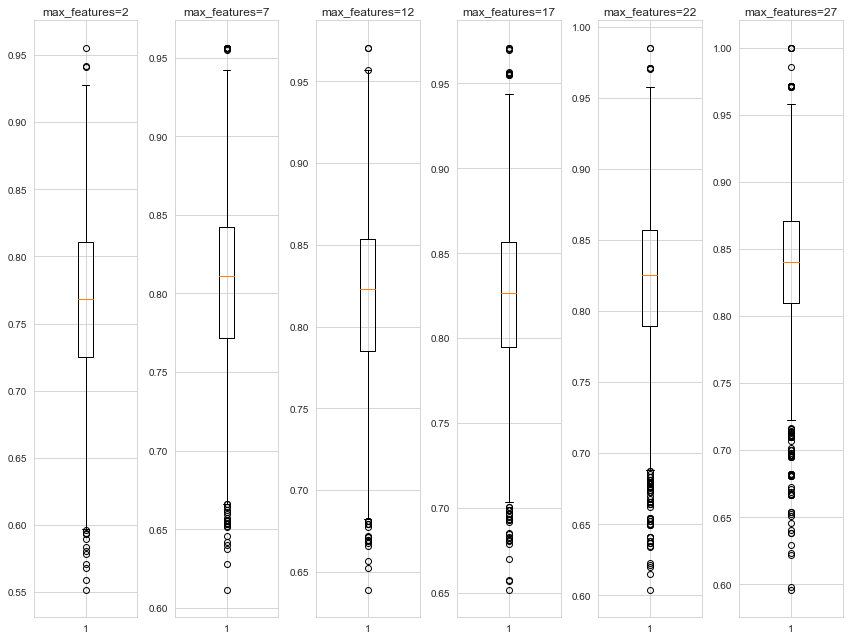

In [194]:
plot_place=1
for i in range(2, 28, 5):
    clf = RandomForestClassifier(max_features=i)
    clf.fit(X_train, y_train)
    corr = base_model_pair_correlation(clf, X_test)
    plt.subplot(1,6,plot_place)
    plot_place += 1
    plt.tight_layout()
    plt.title(f'max_features={i}')
    plt.boxplot(corr)

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

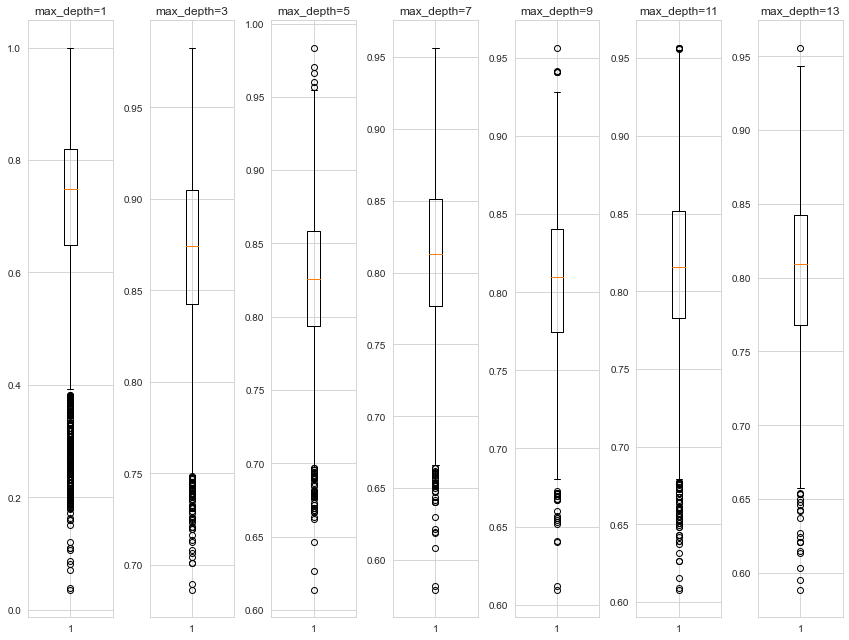

In [198]:
plot_place=1
for i in range(1,15,2):
    clf = RandomForestClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    corr = base_model_pair_correlation(clf, X_test)
    plt.subplot(1,7,plot_place)
    plot_place += 1
    plt.tight_layout()
    plt.title(f'max_depth={i}')
    plt.boxplot(corr)

Опишите ваши наблюдения:

* Для параметра `max_features` - при переходе от 2 к 7 корелляция увеличивается сильнее, чем потом при дальнейшем увеличении количества фичей
* Для параметра `max_depth` - при переходе от 1 к 3 корелляция сильно увеличивается, затем падает и остается примерно на одном уровне

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).

In [370]:
heart_dataset = pd.read_csv("data/heart.csv")

In [371]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [372]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [373]:
voting_hard = VotingClassifier(base_models, voting='hard')
voting_soft = VotingClassifier(base_models, voting='soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    model.fit(X_train, y_train)

scores_table = pd.DataFrame({'model_name': [], 'score':[]})
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    scores_table.loc[len(scores_table)] = [model.__class__.__name__, scores.mean()]
    # print(f"{model.__class__.__name__}: {scores.mean()}")

[03:19:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:19:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:19:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:19:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [374]:
scores_table

,model_name,score
0,DecisionTreeClassifier,0.797997
1,RandomForestClassifier,0.832875
2,CatBoostClassifier,0.834272
3,ExtraTreesClassifier,0.828175
4,KNeighborsClassifier,0.649331
5,SVC,0.840310
6,SVC,0.697312
7,XGBClassifier,0.820158
8,LGBMClassifier,0.817011
9,XGBRFClassifier,0.837963


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [378]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [376]:
voting_clf = VotingClassifier(base_models, voting='soft')
voting_clf.fit(X_train, y_train)

[03:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=111)),
                             ('ETC', ExtraTreesClassifier(random_state=111)),
                             ('KNN', KNeighborsClassifier(weights='distance')),
                             ('SVC_LIN',
                              SVC(kernel='linear', probability=True,
                                  random_state=111)),
                             ('SVC_RBF',
                              SV...
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                    

In [380]:
correlats = base_model_pair_correlation_for_voting_clf(voting_clf, X_test)

In [381]:
correlats

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8134894007824364),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  ExtraTreesClassifier(random_state=111),
  0.7749544834941163),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.31332949662835446),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.715376472596946),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(probability=True, random_state=111),
  0.28201353566953785),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  0.7875690140798687),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111),
  0.8282760696670941),

Попробуем удалить Cat, ET, LGBM_RF и XGB

In [383]:
base_models = [("DT", dt), ("RF", rf),
               ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("LGBM", lgbm),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [384]:
voting_clf = VotingClassifier(base_models, voting='soft')
voting_clf.fit(X_train, y_train)

[03:38:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=111)),
                             ('KNN', KNeighborsClassifier(weights='distance')),
                             ('SVC_LIN',
                              SVC(kernel='linear', probability=True,
                                  random_state=111)),
                             ('SVC_RBF',
                              SVC(probability=True, random_state=111)),
                             ('LGBM', L...
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                   

In [389]:
prediction = voting_clf.predict(X_test)
f1_score(y_test, prediction)

0.8627450980392157

Стало чуть лучше

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [343]:
data = pd.read_csv("data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [344]:
X = data.drop(columns=['Churn?'])
y = data['Churn?']

Убрала колонки с названием штата, номером телефона и кодом места, потому что они вряд ли несут важную информацию для дальнейшей работы

In [345]:
X = X.drop(columns=['State', 'Phone', 'Area Code', 'Phone'])

Перевела строковые значения в 1 и 0, и убрала колонки с дублирующейся информацией

In [346]:
X = pd.get_dummies(X)

In [347]:
X = X.drop(columns=['Int\'l Plan_no', 'VMail Plan_no'])

In [231]:
X.head()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan_yes,VMail Plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,1
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,1
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1,0


In [348]:
y = pd.get_dummies(y)
y = y.drop(columns='False.')

In [230]:
y.head()

,True.
0,0
1,0
2,0
3,0
4,0


In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

<AxesSubplot:>

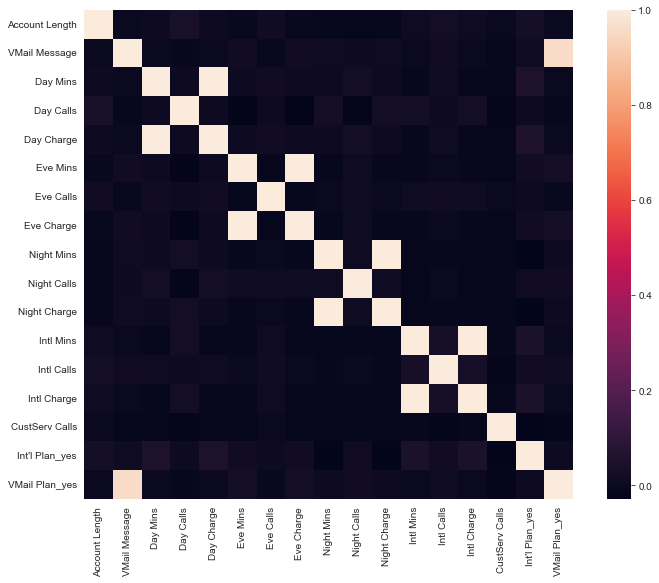

In [236]:
corr = X.corr()
sns.heatmap(corr, square=True)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

### Бустинг из библиотеки lightgbm

In [295]:
boosting = lightgbm.LGBMClassifier()
boosting.fit(X_train, y_train)
boost_prediction = boosting.predict(X_test)
f1 = f1_score(y_test, boost_prediction)
f1

0.8627450980392157

Попробуем улучшить

In [296]:
params = {'max_depth': range(3,12,2),
          'num_leaves': range(6,60,8),
          'n_estimators':range(1,10,3),
          'learning_rate': np.linspace(0.01,0.3,10)}

In [297]:
search = GridSearchCV(boosting, params, cv=3)
search.fit(X_train, y_train)
best_tree1 = search.best_estimator_

In [298]:
best_tree1

LGBMClassifier(learning_rate=0.23555555555555557, max_depth=3, n_estimators=4,
               num_leaves=6)

In [287]:
boosting = lightgbm.LGBMClassifier(max_depth=3, n_estimators=7, learning_rate=0.24, num_leaves=6)
boosting.fit(X_train, y_train)
boost_prediction = boosting.predict(X_test)
f1 = f1_score(y_test, boost_prediction)

In [288]:
f1

0.8571428571428572

Почему-то стало только хуже :(

### Лес из этой же библиотеки

In [313]:
rf_light = lightgbm.LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, boosting_type="rf")
rf_light.fit(X_train, y_train)
rf_prediction = rf_light.predict(X_test)
f1 = f1_score(y_test, rf_prediction)
f1

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


0.8627450980392157

In [314]:
params = {'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
          'bagging_freq': [2, 4, 5, 6, 8]}
search = GridSearchCV(boosting, params, cv=3)
search.fit(X_train, y_train)
best_tree1 = search.best_estimator_

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagg

In [315]:
best_tree1

LGBMClassifier(bagging_fraction=0.7, bagging_freq=2, boosting_type='rf',
               learning_rate=0.24, max_depth=3, n_estimators=7, num_leaves=6)

In [320]:
rf_light = lightgbm.LGBMClassifier(bagging_fraction=0.7, bagging_freq=2, boosting_type='rf',
               learning_rate=0.24, max_depth=3, n_estimators=7, num_leaves=6)
rf_light.fit(X_train, y_train)
rf_prediction = rf_light.predict(X_test)
f1 = f1_score(y_test, rf_prediction)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [321]:
f1

0.8600000000000001

Опять только хуже:(

Попробуем убрать кореллирующие значения и запустить все снова с теми же параметрами

In [356]:
X = X.drop(columns=['Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins', 'VMail Message'])

KeyError: "['Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins', 'VMail Message'] not found in axis"

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

Бустинг

In [364]:
boosting = lightgbm.LGBMClassifier(max_depth=3, n_estimators=7, learning_rate=0.24, num_leaves=6)
boosting.fit(X_train, y_train)
boost_prediction = boosting.predict(X_test)
f1 = f1_score(y_test, boost_prediction)

In [365]:
f1

0.6891891891891893

In [368]:
rf_light = lightgbm.LGBMClassifier(bagging_fraction=0.7, bagging_freq=2, boosting_type='rf',
               learning_rate=0.24, max_depth=3, n_estimators=7, num_leaves=6)
rf_light.fit(X_train, y_train)
rf_prediction = rf_light.predict(X_test)
f1 = f1_score(y_test, rf_prediction)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [369]:
f1

0.6481481481481481

Стало совсем плохо

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

**Вместо того, чтобы нарисовать свои эмоции при выпонении дз, я решила нарисовать просто что-нибудь позитивное, что поможет поднять настроение :)**


<img src="https://sun9-4.userapi.com/impf/Prldsdn6xc_KFzFQYpzd86uuypIoPL2IsWPiVw/Iwn45zo4_nM.jpg?size=800x800&quality=95&sign=709060aab22022308299a40d50539188&type=album" weigh="50" heigh="50">

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**